In [1]:
%matplotlib inline
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
from importlib import reload
import numpy as np

import matplotlib.pyplot as plt

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainimagesource, trainutils, pytorchutils, pytorchnet,datasource

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
   
latentShape=100

0.4.1.post2


float32 (1, 1, 28, 28) float32 (1, 1)


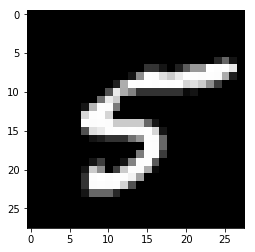

In [2]:
dat=np.load('mnist.npz')

trainImg=dat['trainImg'].astype(np.float32)
trainCat=np.ones((trainImg.shape[0],1),np.float32)*pytorchutils.DiscriminatorMgr.realLabel

src=datasource.DataSource(trainImg[...,np.newaxis]/trainImg.max(),trainCat,augments=[pytorchutils.convertFirst])

with src.threadBatchGen(1) as gen:
    im,cat=gen()
    
print(im.dtype,im.shape,cat.dtype,cat.shape)
plt.imshow(im[0,0])

In [3]:
gensrc=datasource.randomDataSource((latentShape,1))

with gensrc.threadBatchGen(1) as gen:
    latent,_=gen()
    print(latent.shape,latent.flatten()[:10])

(1, 100, 1) [ 2.2267654  -0.44383588  0.13880447  0.6409772  -2.1273723  -0.48432833
  0.39391762 -1.426904   -0.5035282  -1.3541405 ]


In [4]:
class GeneratorNBMgr(pytorchutils.GeneratorMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,disc,savedirprefix=None,loss=None,**params):
        self.src=src
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.GeneratorMgr.__init__(self,net,disc,savedirprefix,loss,**params)
        
    def run(self):
        with self.src.threadBatchGen(self.params['batchSize']) as gen:
            self.train(gen,self.params['trainSteps'],self.params['substeps'])
    
    def trainStep(self,numSubsteps=1):
        dparams=self.disc.params
        self.disc.trainDiscriminator(dparams['batchSize'],dparams['trainSteps'],1)
        pytorchutils.GeneratorMgr.trainStep(self,numSubsteps)
            
    def evalStep(self,index,steploss,results):
        results.append(self.toNumpy(self.netoutputs[0]))
    
    def updateStep(self,step,steploss):
        pytorchutils.GeneratorMgr.updateStep(self,step,steploss)
        
        lossvals={
            'lossGen':steploss,
            'lossDisc':self.disc.lossoutput.mean().item() if self.disc.lossoutput else 0
        }
        
        self.updateGraphVals(lossvals,tuple(lossvals.keys()))
        
        if step<10 or step%20==0:
            images,images2=self.traininputs
            gens=self.toNumpy(self.netoutputs[0])
            tile=trainutils.tileStack(gens[:30],10,3)
            self.updateImageVals({'Generated Images':tile.transpose(1,2,0)})

            

batchSize=500
learningRate=2e-4
betas=(0.5,0.999)
isCuda=True

discparams={
    'batchSize':batchSize,
    'learningRate':learningRate,
    'betas':betas,
    'isCuda':isCuda,
    
    'inShape':(28,28,1),
    'trainSteps':1,
    'channels':(8, 16, 32, 64, 1), 
    'strides': (2,  2,  2,  2, 1),
    'numSubunits':5,
    'kernelSize':5,
}    

genparams={
    'batchSize':batchSize,
    'learningRate':learningRate,
    'betas':betas,
    'isCuda':isCuda,
    
    'latentShape':latentShape,
    'startShape':(7,7,latentShape), # startShape, channels, and strides chosen carefully to produce (1,28,28) output
    'trainSteps':2000,
    'substeps':1,
    'channels':(64, 32, 1), 
    'strides': ( 2,  2, 1),
    'numSubunits':0,
    'kernelSize':3,
}


netDisc=trainutils.applyArgMap(pytorchnet.Discriminator,**discparams)
netGen=trainutils.applyArgMap(pytorchnet.Generator,**genparams)

netGen.conv.add_module('activation',torch.nn.Sigmoid()) # set final activation to sigmoid since MNIST is on [0,1] interval

netDisc.apply(pytorchnet.normalInit)
netGen.apply(pytorchnet.normalInit)

discmgr=pytorchutils.DiscriminatorMgr(netDisc,src,**discparams)
genmgr=GeneratorNBMgr(netGen,gensrc,discmgr,**genparams)

testim=discmgr.convertArray(im)
testlatent=genmgr.convertArray(latent).float()
print('Discriminator output:',netDisc(testim)[0].item())
print('Generator output size:',netGen(testlatent)[0].shape)

genmgr.start()

Discriminator output: 0.5006636381149292
Generator output size: torch.Size([1, 1, 28, 28])


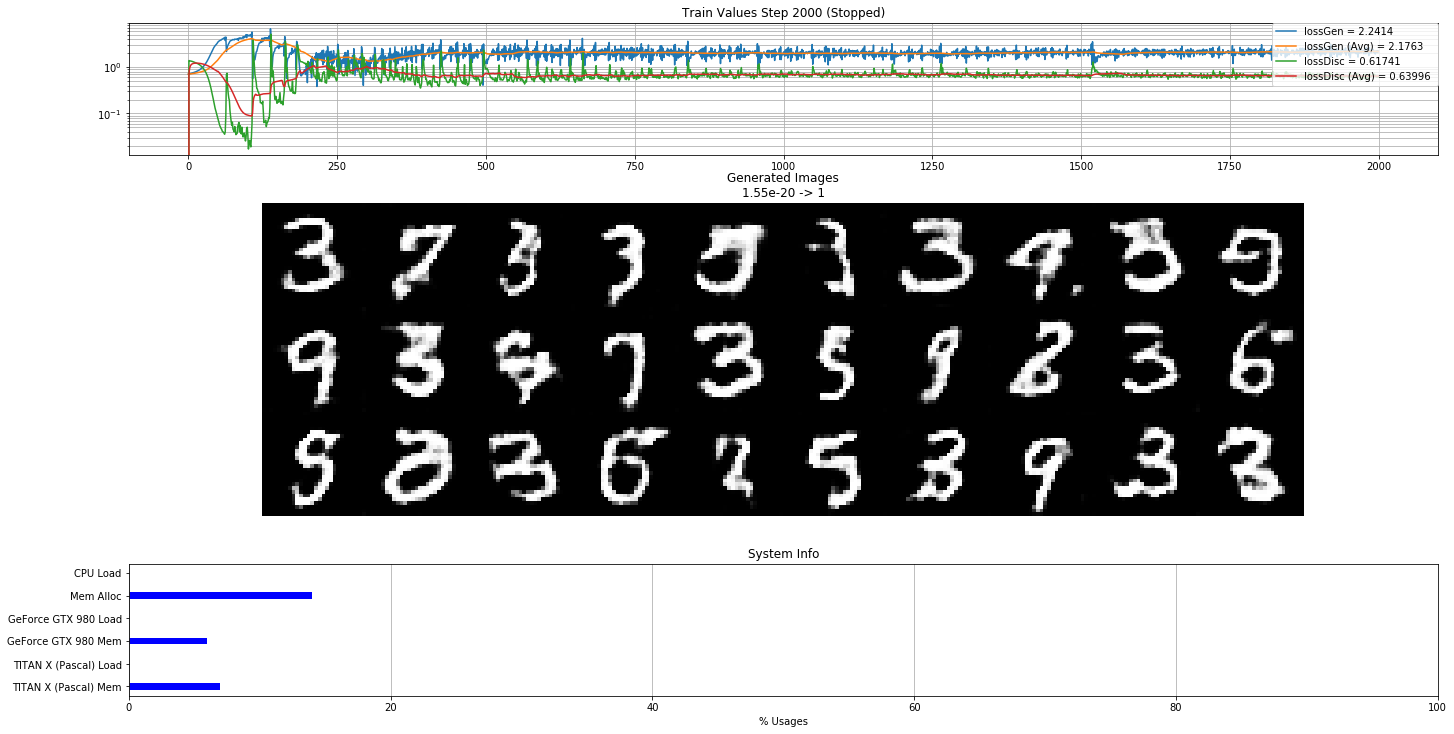

In [5]:
genmgr.displayMonitor()